# Scraping Script

Processing the scraped data is further below

In [1]:
import asyncio
import nest_asyncio
import csv
import datetime
from dotenv import load_dotenv
import os

from telethon import TelegramClient, events, sync
from telethon.tl.functions.messages import GetHistoryRequest
import pandas as pd

import numpy as np
import pandas as pd
import re

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# for the data labelling, comment out if not used
from tqdm.notebook import tqdm
import ollama

from pydantic import BaseModel, Field, ValidationError
from typing import Dict, List, Literal

In [87]:
load_dotenv()
api_id = os.getenv("TELE_API") 
api_hash = os.getenv("TELE_HASH")
session_name = 'tele_scrape_btc'

nest_asyncio.apply()

For reference, these are the channel names, handles and IDs

IDs may differ between users so the handles are provided here for reproducibility

* Channel Name: Crypto Pump Club 📈, Tele Handle: cryptoclubpump
* Channel Name: Binance Killers®, Tele Handle: binancekillers
* Channel Name: Technical CRYPTO Analyst, Tele Handle: TechCryptoAnalyst
* Channel Name: Fed. Russian Insiders®, Tele Handle: FedRussianInsiders
* Channel Name: Wallstreet Queen Official®, Tele Handle: wallstreetqueenofficial
* Channel Name: Whales Crypto Guide, Tele Handle: Whalesguide

In [88]:
chat_names = ["Crypto Pump Club", "Binance Killers", "Wallstreet Queen Official", "Technical CRYPTO Analyst", "Whales Crypto Guide", "Fed. Russian Insiders"]

In [89]:
chats = {}
async def find_channel(channel_names):
    """ Function to find the correct ID of channel or group chats

    Args:
        channel_names (list(str)): list of strings of partial channel names to search for
    
    Outputs:
        prints matched channels with their IDs
    """
    
    async with TelegramClient(session_name, api_id, api_hash) as client:
        
        dialogs = await client.get_dialogs()
        channels = [dialog for dialog in dialogs if dialog.is_channel]

        for channel in channels:
            if any(channel_name.lower() in channel.name.lower() for channel_name in channel_names):
                print(f"{channel.name} found with id: {channel.entity.id}, username: {channel.entity.username}")
                chats[channel.name] = [channel.entity.id, channel.entity.username]

asyncio.run(find_channel(chat_names))


Crypto Pump Club 📈 found with id: 1625691880, username: cryptoclubpump
Binance Killers® found with id: 1220789766, username: binancekillers
Technical CRYPTO Analyst found with id: 1349397698, username: TechCryptoAnalyst
Fed. Russian Insiders® found with id: 1317169843, username: FedRussianInsiders
Wallstreet Queen Official® found with id: 1347728413, username: wallstreetqueenofficial
Whales Crypto Guide found with id: 1288385100, username: Whalesguide


In [90]:
for name, data in chats.items():
    print(f"Channel Name: {name}, Tele Handle: {data[1]}")
    print(f"ID: {data[0]}", end="\n\n")

Channel Name: Crypto Pump Club 📈, Tele Handle: cryptoclubpump
ID: 1625691880

Channel Name: Binance Killers®, Tele Handle: binancekillers
ID: 1220789766

Channel Name: Technical CRYPTO Analyst, Tele Handle: TechCryptoAnalyst
ID: 1349397698

Channel Name: Fed. Russian Insiders®, Tele Handle: FedRussianInsiders
ID: 1317169843

Channel Name: Wallstreet Queen Official®, Tele Handle: wallstreetqueenofficial
ID: 1347728413

Channel Name: Whales Crypto Guide, Tele Handle: Whalesguide
ID: 1288385100



In [ ]:
async def fetch_messages():
    df = pd.DataFrame(columns=["channel", "text", "date"])
    earliest_msg = datetime.datetime(2024, 1, 1) # March 1st as temporary testing
    async with TelegramClient(session_name, api_id, api_hash) as client:
        await client.start()
        for _, (channel_id, channel_handle) in chats.items():
            
            channel = await client.get_entity(channel_id)
            print(channel.title)
            messages = []
            async for message in client.iter_messages(channel, reverse=True, offset_date=earliest_msg, limit=None): # adjust limit as necessary
                messages.append({
                    "channel": channel_handle,
                    #"sender": int(message.sender_id),
                    "text": message.text,
                    "date": message.date
                }) 
            df = pd.concat([df, pd.DataFrame(messages)], ignore_index=True)
        df.to_csv("../data/raw/tele_channel_messages.csv", encoding="utf-8-sig", index=False)

asyncio.run(fetch_messages())

Crypto Pump Club 📈


C:\Users\chewy\AppData\Local\Temp\ipykernel_30908\154518636.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(messages)], ignore_index=True)


Binance Killers®
Technical CRYPTO Analyst
Fed. Russian Insiders®
Wallstreet Queen Official®
Whales Crypto Guide


# Cleaning up data

In [2]:
df = pd.read_csv(r"../data/raw/tele_channel_messages.csv")

In [3]:
print(df.isna().sum())
df = df.dropna()
print(df.info())

channel      0
sender       0
text       447
date         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 17747 entries, 0 to 18193
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   channel  17747 non-null  object
 1   sender   17747 non-null  int64 
 2   text     17747 non-null  object
 3   date     17747 non-null  object
dtypes: int64(1), object(3)
memory usage: 693.2+ KB
None


In [4]:
df = df.drop(columns=["sender"], axis=0)
df.head()

,channel,text,date
0,cryptoclubpump,**HAPPY NEW YEAR ❤️\n\n**We vow to provide you...,2024-01-01 14:13:15+00:00
1,cryptoclubpump,We’re planning our next pump for this Sunday. ...,2024-01-01 14:14:15+00:00
2,cryptoclubpump,‼️ **MAJOR** **PUMP ANNOUNCEMENT **‼️\n\nHere’...,2024-01-02 13:48:18+00:00
3,cryptoclubpump,**‼️ 5 DAYS UNTIL THE PUMP ON MEXC**,2024-01-02 15:00:49+00:00
4,cryptoclubpump,**‼️ 4 DAYS UNTIL THE PUMP ON MEXC\n\n**In jus...,2024-01-03 15:00:04+00:00


In [5]:
df = df.dropna(subset=['channel']).reset_index(drop=True)
encoder = OneHotEncoder(sparse=False, drop=None)
encoded_senders = encoder.fit_transform(df[['channel']])
encoded_df = pd.DataFrame(encoded_senders, columns=encoder.get_feature_names_out(['channel']), index=df.index)
df = df.drop(columns=['channel']) 
df = pd.concat([df, encoded_df], axis=1) 

In [6]:
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
        text = re.sub(r'[^\x00-\x7F]+', '', text)  # remove non-ASCII characters (emojis)
    return text

df["text"] = df["text"].apply(clean_text)

In [7]:
df.head()

,text,date,channel_FedRussianInsiders,channel_TechCryptoAnalyst,channel_Whalesguide,channel_binancekillers,channel_cryptoclubpump,channel_wallstreetqueenofficial
0,**HAPPY NEW YEAR **We vow to provide you with...,2024-01-01 14:13:15+00:00,0.0,0.0,0.0,0.0,1.0,0.0
1,Were planning our next pump for this Sunday. W...,2024-01-01 14:14:15+00:00,0.0,0.0,0.0,0.0,1.0,0.0
2,**MAJOR** **PUMP ANNOUNCEMENT ** Heres the de...,2024-01-02 13:48:18+00:00,0.0,0.0,0.0,0.0,1.0,0.0
3,** 5 DAYS UNTIL THE PUMP ON MEXC**,2024-01-02 15:00:49+00:00,0.0,0.0,0.0,0.0,1.0,0.0
4,** 4 DAYS UNTIL THE PUMP ON MEXC **In just fou...,2024-01-03 15:00:04+00:00,0.0,0.0,0.0,0.0,1.0,0.0


In [8]:
# keywords, if we can have a moderately fast method to assess reliably if news affects btc or bitcoin like crypto outlook, will be even better
keywords = ['bitcoin', 'btc']
df = df[df['text'].str.contains('|'.join(keywords), case=False, na=False)]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3948 entries, 173 to 17745
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   text                             3948 non-null   object 
 1   date                             3948 non-null   object 
 2   channel_FedRussianInsiders       3948 non-null   float64
 3   channel_TechCryptoAnalyst        3948 non-null   float64
 4   channel_Whalesguide              3948 non-null   float64
 5   channel_binancekillers           3948 non-null   float64
 6   channel_cryptoclubpump           3948 non-null   float64
 7   channel_wallstreetqueenofficial  3948 non-null   float64
dtypes: float64(6), object(2)
memory usage: 277.6+ KB


In [10]:
# remove duplicates
orig_size = df.shape[0]
df = df.drop_duplicates(subset=["text"])

print(f"Dataset size after removing duplicates from {orig_size} to {df.shape[0]}")

Dataset size after removing duplicates from 3948 to 3298


In [11]:
# remove short sentences
orig_size = df.shape[0]
df['words'] = [len(x.split()) for x in df['text'].tolist()]
df = df[df["words"] > 5 ]
df = df[df["words"] < 256]
df = df.drop(columns=["words"])

print(f"Dataset size after filtering from {orig_size} to {df.shape[0]}")

Dataset size after filtering from 3298 to 3240


In [115]:
df.to_csv(r"../data/processed/tele_messages_processed.csv")

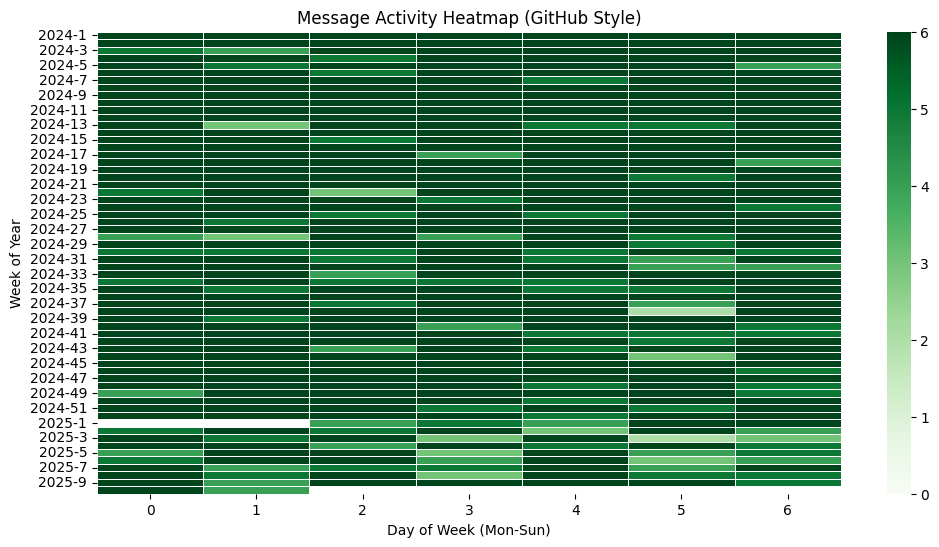

In [12]:
df['date'] = pd.to_datetime(df['date'])

df['year'] = df['date'].dt.year
df['week'] = df['date'].dt.isocalendar().week
df['day'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6

heatmap_data = df.groupby(['year', 'week', 'day']).size().unstack()

plt.figure(figsize=(12, 6))
ax = sns.heatmap(heatmap_data, cmap="Greens", linewidths=0.5, linecolor="white", vmin=0, vmax=6)
ax.set_xlabel("Day of Week (Mon-Sun)")
ax.set_ylabel("Week of Year")
ax.set_title("Message Activity Heatmap (GitHub Style)")

plt.show()

just take note here that first 2 days of 2025 has no news

In [13]:
# df = pd.read_csv(r"../data/processed/tele_messages_processed.csv")
class Sentiment(BaseModel):
    """ Sentiment of Bitcoin outlook from the financial news"""
    sentiment: Literal["positive", "negative", "neutral"]

    @classmethod
    def from_response(cls, response: str):
        """Parse and validate response from Ollama"""
        try:
            normalized_response = response.strip().lower()  
            if normalized_response not in {"positive", "negative", "neutral"}:
                raise ValueError(f"Unexpected sentiment: {normalized_response}")
            return cls(sentiment=normalized_response)
        except (ValidationError, ValueError) as e:
            print(f"Error parsing response: {e}; Response: {response}")
            return cls(sentiment="neutral")  # fallback to neutral

In [14]:
model_name = "llama3.1:8b"
def get_sentiment(text):
    prompt = f"""Analyze the sentiment of the following crypto financial text to determine if the outlook on Bitcoin or BTC is positive.
    Text: "{text}"
    
    Provide a single-word label: Positive, Negative, or Neutral.
    Only return the label without additional text.

    Take note that a positive outlook on the crypto market also means that it will result in a positive outlook on Bitcoin and vice versa.
    For example:
    Text:
    Pump into Crypto, market looks good!

    Sentiment: Positive
    """
    
    response = ollama.chat(model=model_name, messages=[{"role": "user", "content": prompt}])
    
    return Sentiment.from_response(response["message"]["content"])

In [15]:
tqdm.pandas()
df["sentiment"] = df["text"].progress_apply(get_sentiment)
df["sentiment"] = df["sentiment"].apply(lambda x: x.sentiment if isinstance(x, Sentiment) else x)

  0%|          | 0/3240 [00:00<?, ?it/s]

Error parsing response: Unexpected sentiment: positive.; Response: Positive.
Error parsing response: Unexpected sentiment: positive.; Response: Positive.
Error parsing response: Unexpected sentiment: neutral.; Response: Neutral.
Error parsing response: Unexpected sentiment: positive.; Response: Positive.
Error parsing response: Unexpected sentiment: neutral.; Response: Neutral.
Error parsing response: Unexpected sentiment: positive.; Response: Positive.
Error parsing response: Unexpected sentiment: positive.; Response: Positive.
Error parsing response: Unexpected sentiment: neutral

reasoning: the sentiment analysis is based on the bitcoin fear and greed index being 77 (extreme greed), which typically indicates a high level of investor confidence. however, the label "fear" rather than "greed" might be more suitable in this context as it suggests a sense of uncertainty or unease among investors due to extremely high levels of greed. nevertheless, since a neutral response is given for th

In [18]:
counts = df["sentiment"].value_counts()
print(counts)
df.to_csv(r"../data/processed/tele_messages_processed_hourly.csv")

sentiment
positive    2261
neutral      574
negative     405
Name: count, dtype: int64


In [16]:
# Viewing sentiments randomly, 10 of each
sampled_texts = df.groupby("sentiment")["text"].apply(lambda x: x.sample(n=10, random_state=42, replace=True)).reset_index()

output_text = ""
for sentiment in ["positive", "negative", "neutral"]:
    output_text += f"\n=== {sentiment.upper()} ===\n"
    if sentiment in sampled_texts["sentiment"].values:
        texts = sampled_texts[sampled_texts["sentiment"] == sentiment]["text"].tolist()
        output_text += "\n".join(f"- {t}" for t in texts)
    else:
        output_text += "No examples found.\n"

print(output_text)


=== POSITIVE ===
- $BTC VIP Analysis January 05, 2024 ------------------- BIAS: Mid-Term: BULLISH Short-Term: BULLISH -------------------- As expected the price action of $BTC successfully showed us the further upward movements after the candle closure above the level and went up towards its 2nd FVG level. Currently, the price action is forming out Double Top pattern level where we can see a short bounce back level before the downward movements -------------------- MAIN INTEREST LEVELS SHORT $44,190 LONG $44,331 PREDICTED DAILY RANGE $45,009 - $42,229 -------------------- VIP ACTION PLAN [VIP EXCLUSIVE CONTENT] -------------------- Yours truly, Federal Russian Insiders
- $BTC VIP Analysis AUGUST 24th, 2024 ------------------- BIAS: Mid-Term: BULLISH Short-Term: BULLISH -------------------- The price action, after retesting and holding the support region, is showing potential movement towards squeezing out the upper side liquidity level.  On the daily timeframe, the price action has al

In [17]:
df = pd.read_csv(r"../data/processed/tele_messages_processed_hourly.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/tele_messages_processed_hourly.csv'

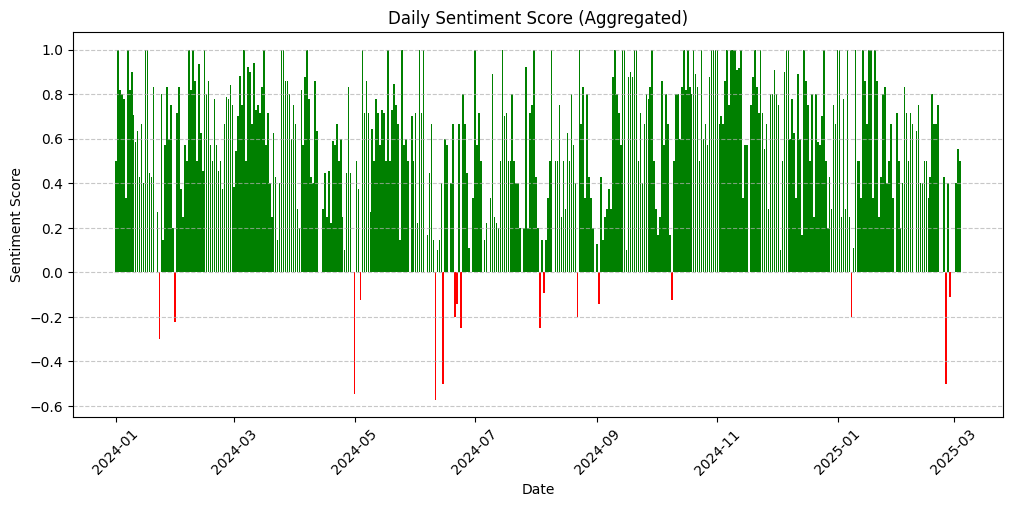

In [ ]:

# df["date"] = pd.to_datetime(df["date"]).dt.date  # Keep only the date part

# Map sentiment values to numerical scores
sentiment_mapping = {"positive": 1, "negative": -1, "neutral": 0}
df["sentiment_score"] = df["sentiment"].map(sentiment_mapping)

# Aggregate sentiment scores per day
daily_sentiment = df.groupby("date")["sentiment_score"].mean()

# Plot sentiment over time (GitHub-style heatmap)
plt.figure(figsize=(12, 5))
plt.bar(daily_sentiment.index, daily_sentiment.values, color=np.where(daily_sentiment > 0, 'green', 'red'))

plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.title("Daily Sentiment Score (Aggregated)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()



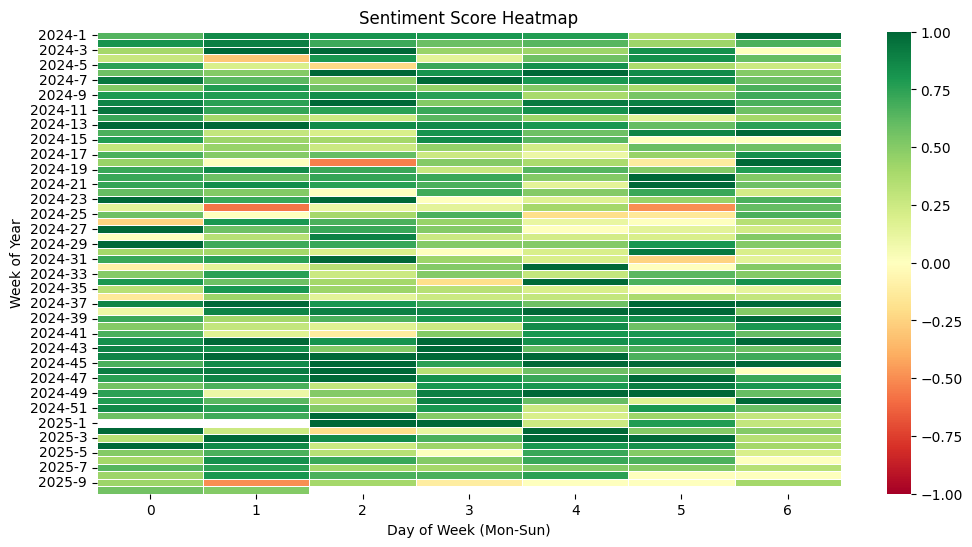

In [32]:
df["date"] = pd.to_datetime(df["date"])

# Map sentiment values to numerical scores
sentiment_mapping = {"positive": 1, "negative": -1, "neutral": 0}
df["sentiment_score"] = df["sentiment"].map(sentiment_mapping)

df["year"] = df["date"].dt.year
df["week"] = df["date"].dt.isocalendar().week
df["day"] = df["date"].dt.dayofweek  

heatmap_data = df.groupby(["year", "week", "day"])["sentiment_score"].mean().unstack()

plt.figure(figsize=(12, 6))
ax = sns.heatmap(heatmap_data, cmap="RdYlGn", linewidths=0.5, linecolor="white", center=0, vmin=-1, vmax=1)
ax.set_xlabel("Day of Week (Mon-Sun)")
ax.set_ylabel("Week of Year")
ax.set_title("Sentiment Score Heatmap")
plt.show()
